In [1]:
import os
import glob
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

# Define your data directories
TRAIN_DIR = '/kaggle/input/instant-odc-ai-hackathon/Train'
TEST_DIR = '/kaggle/input/instant-odc-ai-hackathon/test' # Adjust if capitalization differs (e.g. 'Test')

# --- 1. Z-Score Normalization Helper ---
def normalize_volume(vol):
    """
    Normalizes the volume per-channel using Z-score standardization.
    Formula: (x - mean) / std
    We compute statistics only on non-zero pixels (the brain region) to avoid background bias.
    """
    # vol shape: (H, W, D, 4)
    vol_norm = np.zeros_like(vol)
    
    for c in range(4): # Loop through T1, T1ce, T2, FLAIR
        channel = vol[:, :, :, c]
        
        # Calculate stats on non-zero pixels only (the brain)
        mask_brain = channel > 0
        if np.sum(mask_brain) > 0:
            mean = np.mean(channel[mask_brain])
            std = np.std(channel[mask_brain])
            
            # Apply Z-score
            # We verify std != 0 to avoid division by zero
            if std > 0:
                vol_norm[:, :, :, c] = (channel - mean) / std
                
                # Optional: Clip outliers (e.g., between -5 and 5) to stabilize training
                # vol_norm[:, :, :, c] = np.clip(vol_norm[:, :, :, c], -5, 5)
            else:
                vol_norm[:, :, :, c] = channel # Keep as is if flat
        else:
            vol_norm[:, :, :, c] = channel
            
    return vol_norm

def load_case(case_id, root_dir, normalize=True):
    path = os.path.join(root_dir, case_id)

    # Helper to find file paths
    def get_path(pattern):
        matches = glob.glob(os.path.join(path, f"*{pattern}*"))
        if not matches:
            matches = glob.glob(os.path.join(path, f"*{pattern}*"))
            if not matches:
                 raise FileNotFoundError(f"Could not find file with pattern '{pattern}' in {path}")
        return matches[0]

    # Load file paths
    flair_path = get_path("flair")
    t1ce_path = get_path("t1ce") 
    t2_path   = get_path("t2")
    seg_path  = get_path("seg")
    
    # Special handling for T1
    all_t1 = glob.glob(os.path.join(path, "*t1*"))
    t1_path = [p for p in all_t1 if "t1ce" not in p][0]

    # Load Data
    flair_img = nib.load(flair_path)
    affine = flair_img.affine 
    
    flair = flair_img.get_fdata()
    t1    = nib.load(t1_path).get_fdata()
    t1ce  = nib.load(t1ce_path).get_fdata()
    t2    = nib.load(t2_path).get_fdata()
    seg   = nib.load(seg_path).get_fdata()

    # Stack modalities
    X = np.stack([flair, t1, t1ce, t2], axis=-1)
    
    # Normalize if requested
    if normalize:
        X = normalize_volume(X)
    
    # Map 4 -> 3
    seg[seg == 4] = 3
    
    return X, seg, affine


In [2]:
import os
import random
from tqdm import tqdm
import nibabel as nib
import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import shutil
import time

from dataclasses import dataclass
import gc


import torch
import torch.nn as nn
import torch.nn.functional as F


In [3]:
def analyze_class_balance(mask, patient_id):
    """
    Prints a detailed breakdown of the number of voxels and percentage 
    for each tumor sub-region.
    """
    # Define the mapping based on the Hackathon rules (Label 4 mapped to 3)
    class_names = {
        0: "Background",
        1: "Necrotic Core",
        2: "Edema",
        3: "Enhancing Tumor"
    }
    
    total_voxels = mask.size
    
    print(f"Class Imbalance Analysis for {patient_id}:")
    
    # Iterate through all 4 classes (0, 1, 2, 3)
    for label_idx, name in class_names.items():
        count = np.sum(mask == label_idx)
        percentage = (count / total_voxels) * 100
        
        # Format with commas for thousands and 4 decimal places for percent
        print(f"   Label {label_idx} ({name}): {count:,} voxels ({percentage:.4f}%)")

In [4]:
# Load the NIfTI image
sample_image_flair = nib.load(os.path.join("/kaggle/input/instant-odc-ai-hackathon/Train/BraTS2021_00003/BraTS2021_00003_flair.nii/00000017_brain_flair.nii")).get_fdata()
print("Original max value:", sample_image_flair.max())

# Reshape the 3D image to 2D for scaling
sample_image_flair_flat = sample_image_flair.reshape(-1, 1)

Original max value: 3164.0


In [5]:
sample_mask = nib.load("/kaggle/input/instant-odc-ai-hackathon/Train/BraTS2021_00003/BraTS2021_00003_seg.nii/BraTS2021_00003_seg_new.nii").get_fdata()
sample_mask = sample_mask.astype(np.uint8) 

print("Unique classes in the mask", np.unique(sample_mask))
print("Shape of mask: ", sample_mask.shape)

Unique classes in the mask [0 1 2 4]
Shape of mask:  (240, 240, 155)


In [6]:
from sklearn.preprocessing import MinMaxScaler

# Apply scaling
scaler = MinMaxScaler()

sample_image_flair_scaled = scaler.fit_transform(sample_image_flair_flat)

# Reshape it back to the original 3D shape
sample_image_flair_scaled = sample_image_flair_scaled.reshape(sample_image_flair.shape)

print("Scaled max value:", sample_image_flair_scaled.max())
print("Shape of scaled Image: ", sample_image_flair_scaled.shape)
sample_image_t1 = nib.load('/kaggle/input/instant-odc-ai-hackathon/Train/BraTS2021_00003/BraTS2021_00003_t1.nii/00000017_brain_t1.nii').get_fdata()
sample_image_t1 = scaler.fit_transform(sample_image_t1.reshape(-1,sample_image_t1.shape[-1])).reshape(sample_image_t1.shape)
sample_image_t1.shape
sample_image_t1ce = nib.load('/kaggle/input/instant-odc-ai-hackathon/Train/BraTS2021_00003/BraTS2021_00003_t1ce.nii/00000017_brain_t1ce.nii').get_fdata()
sample_image_t1ce = scaler.fit_transform(sample_image_t1ce.reshape(-1,sample_image_t1ce.shape[-1])).reshape(sample_image_t1ce.shape)
sample_image_t1ce.shape
sample_image_t2 = nib.load('/kaggle/input/instant-odc-ai-hackathon/Train/BraTS2021_00003/BraTS2021_00003_t2.nii/00000017_brain_t2.nii').get_fdata()
sample_image_t2 = scaler.fit_transform(sample_image_t2.reshape(-1,sample_image_t2.shape[-1])).reshape(sample_image_t2.shape)
sample_image_t2.shape

Scaled max value: 1.0
Shape of scaled Image:  (240, 240, 155)


(240, 240, 155)

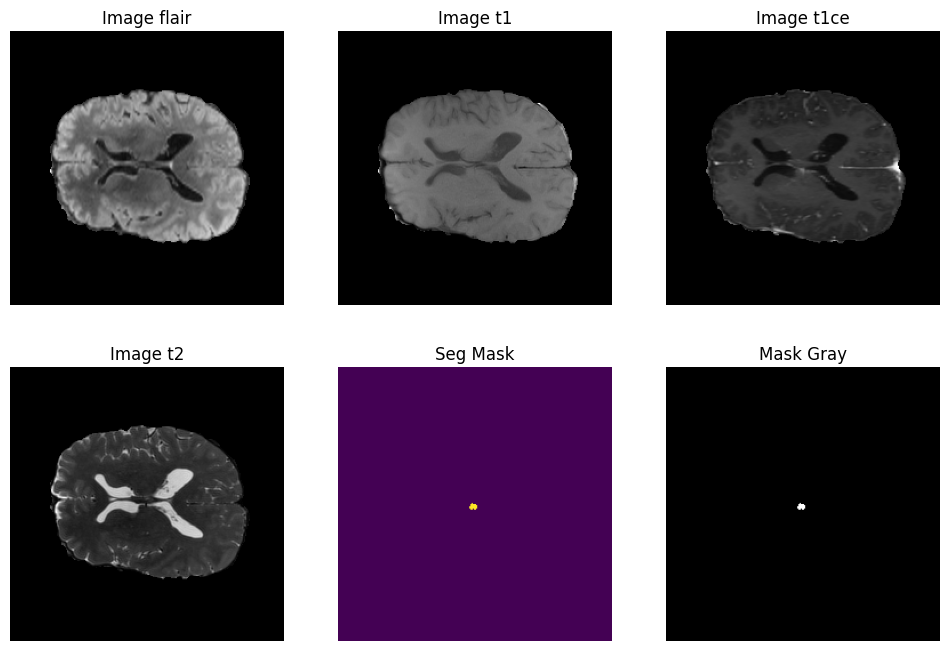

In [7]:
n_slice = 77

plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.imshow(sample_image_flair_scaled[:, :, n_slice], cmap='gray')
plt.title('Image flair')
plt.axis('off')  # Remove axis

plt.subplot(232)
plt.imshow(sample_image_t1[:, :, n_slice], cmap='gray')
plt.title("Image t1")
plt.axis('off')  # Remove axis

plt.subplot(233)
plt.imshow(sample_image_t1ce[:, :, n_slice], cmap='gray')
plt.title("Image t1ce")
plt.axis('off')  # Remove axis

plt.subplot(234)
plt.imshow(sample_image_t2[:, :, n_slice], cmap='gray')
plt.title("Image t2")
plt.axis('off')  # Remove axis

plt.subplot(235)
plt.imshow(sample_mask[:, :, n_slice])
plt.title("Seg Mask")
plt.axis('off')  # Remove axis

plt.subplot(236)
plt.imshow(sample_mask[:, :, n_slice], cmap='gray')
plt.title('Mask Gray')
plt.axis('off')  # Remove axis

# Save without padding and axes
plt.savefig("gt_plot.png", bbox_inches='tight', pad_inches=0)
plt.show()


In [8]:
combined_x = np.stack([sample_image_flair_scaled, sample_image_t1ce, sample_image_t2], axis = 3) 
print("Shape of Combined x ", combined_x.shape)

Shape of Combined x  (240, 240, 155, 3)


Dataset Statistics:
-------------------
Total Train Patients: 917
Total Test Patients:  334
-------------------
Analyzing Case: BraTS2021_01030...


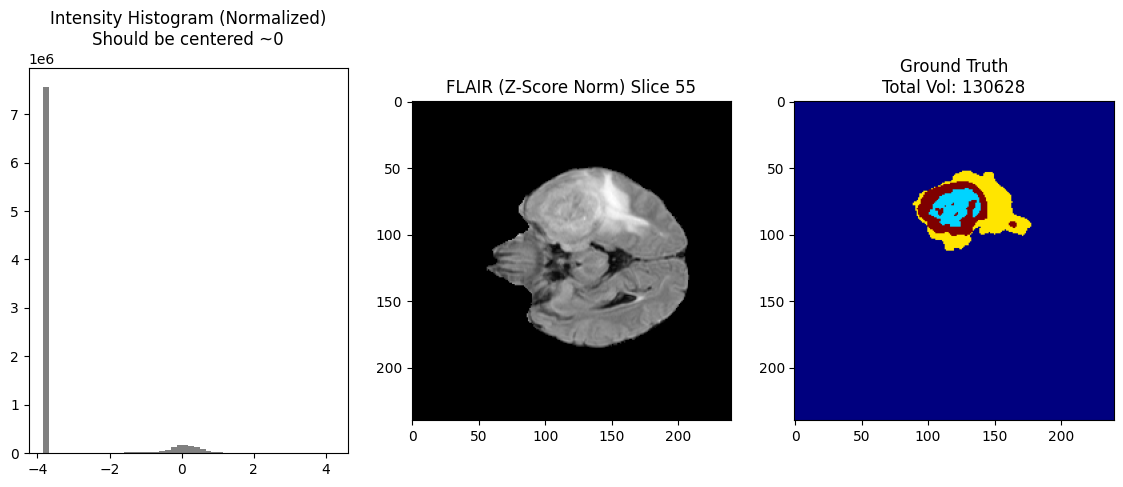

Class Imbalance Analysis for BraTS2021_01030:
   Label 0 (Background): 8,797,372 voxels (98.5369%)
   Label 1 (Necrotic Core): 11,764 voxels (0.1318%)
   Label 2 (Edema): 65,273 voxels (0.7311%)
   Label 3 (Enhancing Tumor): 53,591 voxels (0.6003%)
Affine Matrix:  [[ -1.  -0.  -0.  -0.]
 [ -0.  -1.  -0. 239.]
 [  0.   0.   1.   0.]
 [  0.   0.   0.   1.]]


In [9]:
# --- 2. Data Statistics & Tumor Analysis ---
try:
    # A. Count Patients
    train_ids = [d for d in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR, d))]
    # Check if test dir exists before counting
    if os.path.exists(TEST_DIR):
        test_ids = [d for d in os.listdir(TEST_DIR) if os.path.isdir(os.path.join(TEST_DIR, d))]
    else:
        test_ids = []
        
    print(f"Dataset Statistics:")
    print(f"-------------------")
    print(f"Total Train Patients: {len(train_ids)}")
    print(f"Total Test Patients:  {len(test_ids)}")
    print(f"-------------------")

    # B. Load One Normalized Case
    example_id = train_ids[0]
    print(f"Analyzing Case: {example_id}...")
    X, y, affine = load_case(example_id, TRAIN_DIR, normalize=True)
    
    # C. Tumor Size Calculation
    # Voxel count per class
    ncr_count = np.sum(y == 1) # Necrotic
    ed_count  = np.sum(y == 2) # Edema
    et_count  = np.sum(y == 3) # Enhancing (was 4)
    total_tumor = ncr_count + ed_count + et_count
    

    # Visualization with stats
    slice_idx = np.argmax(np.sum(y > 0, axis=(0, 1)))
    
    plt.figure(figsize=(14, 5))
    
    # Histogram of Intensity (Proof of Normalization)
    plt.subplot(1, 3, 1)
    # Flatten just the brain part for the histogram
    brain_pixels = X[X[:,:,:,0] != 0, 0] 
    plt.hist(brain_pixels, bins=50, color='gray')
    plt.title("Intensity Histogram (Normalized)\nShould be centered ~0")
    
    plt.subplot(1, 3, 2)
    plt.imshow(X[:, :, slice_idx, 0], cmap='gray')
    plt.title(f"FLAIR (Z-Score Norm) Slice {slice_idx}")

    plt.subplot(1, 3, 3)
    plt.imshow(y[:, :, slice_idx], cmap='jet')
    plt.title(f"Ground Truth\nTotal Vol: {total_tumor}")
    
    plt.show()

except Exception as e:
    print(f"Error: {e}")
    import traceback
    traceback.print_exc()
analyze_class_balance(y, example_id)
print(f"Affine Matrix:  {affine}")


In [10]:
import glob
import os

BASE_PATH = '/kaggle/input/instant-odc-ai-hackathon/Train'

# Initialize empty lists
t1ce_list = []
t2_list = []
t1_list = []
flair_list = []
mask_list = []

# 1. Get all Patient Folders (e.g., BraTS2021_00000)
patient_folders = sorted(glob.glob(os.path.join(BASE_PATH, "BraTS2021_*")))
print(f"📂 Found {len(patient_folders)} patient folders. Scanning for files...")

# 2. Loop through each patient to find their files
for patient_path in patient_folders:
    # We use glob inside the patient folder to find the specific files
    # Pattern: PatientFolder -> *flair* (Folder or File) -> *.nii (The file inside)
    # The " recursive=True " logic helps if it's deeply nested
    
    # Find FLAIR
    flair_matches = glob.glob(os.path.join(patient_path, "*flair*", "*.nii"))
    # Fallback: sometimes it's just a file, not a folder
    if not flair_matches: 
        flair_matches = glob.glob(os.path.join(patient_path, "*flair.nii"))
    
    # Find T1CE
    t1ce_matches = glob.glob(os.path.join(patient_path, "*t1ce*", "*.nii"))
    if not t1ce_matches:
        t1ce_matches = glob.glob(os.path.join(patient_path, "*t1ce.nii"))
        
    # Find T1
    t1_matches = glob.glob(os.path.join(patient_path, "*t1*", "*.nii"))
    # (Exclude t1ce from t1 results to be safe, though pattern usually handles it)
    t1_matches = [x for x in t1_matches if 't1ce' not in os.path.basename(x)]
    if not t1_matches:
         t1_matches = glob.glob(os.path.join(patient_path, "*t1.nii"))

    # Find T2
    t2_matches = glob.glob(os.path.join(patient_path, "*t2*", "*.nii"))
    if not t2_matches:
        t2_matches = glob.glob(os.path.join(patient_path, "*t2.nii"))
        
    # Find SEG (Mask)
    seg_matches = glob.glob(os.path.join(patient_path, "*seg*", "*.nii"))
    if not seg_matches:
        seg_matches = glob.glob(os.path.join(patient_path, "*seg.nii"))

    # 3. Validation: Only add if we found exactly ONE of each
    if (len(flair_matches) >= 1 and len(t1ce_matches) >= 1 and 
        len(t1_matches) >= 1 and len(t2_matches) >= 1 and len(seg_matches) >= 1):
        
        # Take the first match (there should only be one valid file per type)
        flair_list.append(flair_matches[0])
        t1ce_list.append(t1ce_matches[0])
        t1_list.append(t1_matches[0])
        t2_list.append(t2_matches[0])
        mask_list.append(seg_matches[0])
    else:
        # If a file is genuinely missing, we print which patient it is
        print(f"⚠️ Skipping {os.path.basename(patient_path)}: Missing files.")
        print(f"   Found: F:{len(flair_matches)} T1c:{len(t1ce_matches)} T1:{len(t1_matches)} T2:{len(t2_matches)} Seg:{len(seg_matches)}")

print("-" * 30)
print(f"✅ Successfully loaded {len(flair_list)} patients.")
print(f"Sample Flair Path: {flair_list[0]}")
print(f"Sample Mask Path:  {mask_list[0]}")

📂 Found 917 patient folders. Scanning for files...
------------------------------
✅ Successfully loaded 917 patients.
Sample Flair Path: /kaggle/input/instant-odc-ai-hackathon/Train/BraTS2021_00000/BraTS2021_00000_flair.nii/00000057_brain_flair.nii
Sample Mask Path:  /kaggle/input/instant-odc-ai-hackathon/Train/BraTS2021_00000/BraTS2021_00000_seg.nii/00000057_final_seg.nii


In [11]:
import numpy as np
import nibabel as nib

# 1. Pick a random patient index
idx = 0 

# 2. Load the raw data for this patient

t1ce = nib.load(t1ce_list[idx]).get_fdata()
t2 = nib.load(t2_list[idx]).get_fdata()
flair = nib.load(flair_list[idx]).get_fdata()
mask = nib.load(mask_list[idx]).get_fdata()

# 3. Create 'combined_x' 
# Structure: (Height, Width, Depth, Channels) -> (240, 240, 155, 3)
combined_x = np.stack([flair, t1ce, t2], axis=-1)

# 4. Create 'sample_mask_c'
sample_mask_c = mask

print(f"Data Loaded!")
print(f"combined_x shape: {combined_x.shape}")
print(f"sample_mask_c shape: {sample_mask_c.shape}")

Data Loaded!
combined_x shape: (240, 240, 155, 3)
sample_mask_c shape: (240, 240, 155)


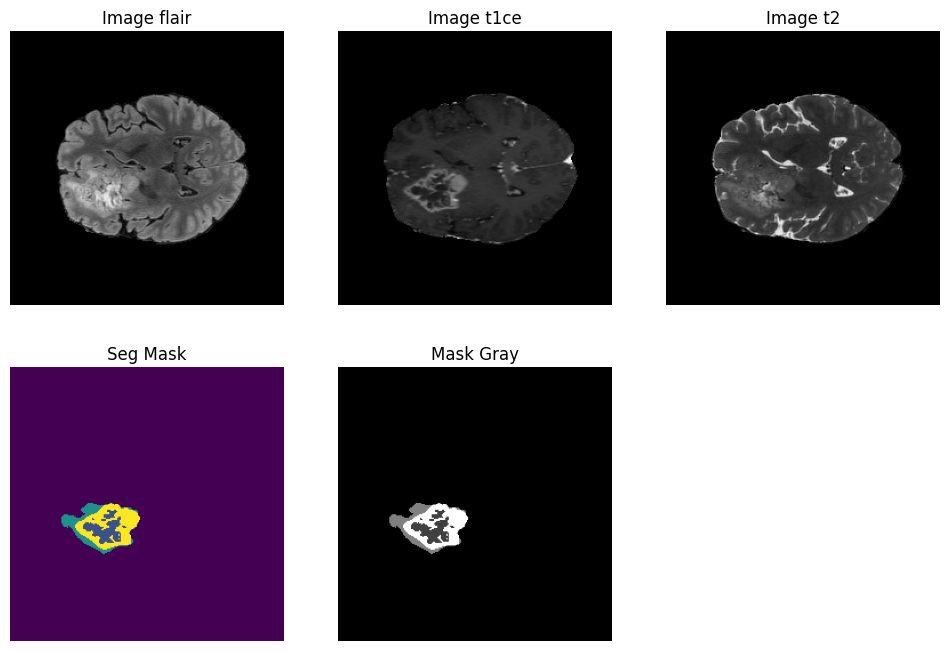

In [12]:
import matplotlib.pyplot as plt
import random

# Randomly select a slice
n_slice = 75 # Ensure slice is within valid range

plt.figure(figsize=(12, 8))

# Display 'Image flair'
plt.subplot(231)
plt.imshow(combined_x[:, :, n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.axis('off')  # Remove axis

# Display 'Image t1ce'
plt.subplot(232)
plt.imshow(combined_x[:, :, n_slice, 1], cmap='gray')
plt.title("Image t1ce")
plt.axis('off')  # Remove axis

# Display 'Image t2'
plt.subplot(233)
plt.imshow(combined_x[:, :, n_slice, 2], cmap='gray')
plt.title("Image t2")
plt.axis('off')  # Remove axis

# Display segmentation mask without gray scale
plt.subplot(234)
plt.imshow(sample_mask_c[:, :, n_slice])
plt.title("Seg Mask")
plt.axis('off')  # Remove axis

# Display segmentation mask in gray scale
plt.subplot(235)
plt.imshow(sample_mask_c[:, :, n_slice], cmap='gray')
plt.title('Mask Gray')
plt.axis('off')  # Remove axis

# Save the figure without padding and axes
plt.savefig("gt_plot.png", bbox_inches='tight', pad_inches=0)
plt.show()


In [13]:
os.makedirs("cropped_data", exist_ok = True)
np.save("cropped_data/combined255.npy", combined_x)

In [14]:
import numpy as np
import nibabel as nib
from scipy.ndimage import zoom, gaussian_filter
import scipy

def normalize_volume_zscore(vol, clip=(-5, 5)):
    """
    Per-modality Z-score over non-zero (brain) voxels, clip outliers.
    vol: (H,W,D,C)
    """
    out = np.zeros_like(vol, dtype=np.float32)
    for c in range(vol.shape[-1]):
        channel = vol[..., c]
        mask = channel != 0
        if np.any(mask):
            m = channel[mask].mean()
            s = channel[mask].std()
            if s <= 0:
                out[..., c] = channel
            else:
                z = (channel - m) / s
                if clip is not None:
                    z = np.clip(z, clip[0], clip[1])
                out[..., c] = z
        else:
            out[..., c] = channel
    return out

def get_brain_bbox(volume, margin=8):
    """Return tight bbox around non‑zero with optional margin."""
    mask = np.any(volume != 0, axis=-1)
    coords = np.array(np.where(mask))
    if coords.size == 0:
        # fallback full volume
        return (0, volume.shape[0], 0, volume.shape[1], 0, volume.shape[2])
    mins = coords.min(axis=1)
    maxs = coords.max(axis=1) + 1
    x0 = max(0, mins[0] - margin)
    x1 = min(volume.shape[0], maxs[0] + margin)
    y0 = max(0, mins[1] - margin)
    y1 = min(volume.shape[1], maxs[1] + margin)
    z0 = max(0, mins[2] - margin)
    z1 = min(volume.shape[2], maxs[2] + margin)
    return (x0, x1, y0, y1, z0, z1)

def crop_to_bbox(vol, bbox):
    x0,x1,y0,y1,z0,z1 = bbox
    return vol[x0:x1, y0:y1, z0:z1, ...]

def resample_volume(img, target_spacing=(1.0,1.0,1.0)):
    """
    Resample NIfTI image to isotropic spacing. Use nibabel to read affine.
    Returns numpy array and new affine.
    NOTE: Optional; only use if input spacing differs across cases.
    """
    data = img.get_fdata()
    affine = img.affine
    # compute current spacing from affine diagonal (approx)
    sx = np.linalg.norm(affine[:3,0])
    sy = np.linalg.norm(affine[:3,1])
    sz = np.linalg.norm(affine[:3,2])
    current = (sx, sy, sz)
    zooms = tuple(cs/ts for cs, ts in zip(current, target_spacing))
    data_res = zoom(data, zoom=zooms, order=1)  # linear
    # recompute affine roughly (not exact)
    new_affine = np.copy(affine)
    new_affine[:3,0] = affine[:3,0] / zooms[0]
    new_affine[:3,1] = affine[:3,1] / zooms[1]
    new_affine[:3,2] = affine[:3,2] / zooms[2]
    return data_res, new_affine

# Label remapping helper
def remap_labels(mask):
    """
    Input ground truth contains {0,1,2,4}. We remap 4->3 in internal representation
    so classes = [0,1,2,3] where 3 corresponds to "4" in original GT.
    """
    m = mask.copy()
    m[m == 4] = 3
    return m.astype(np.uint8)

In [15]:
import numpy as np
from scipy.ndimage import rotate, zoom, gaussian_filter

def random_flip(vol, mask):
    if np.random.rand() < 0.5:
        vol = vol[::-1, ...]
        mask = mask[::-1, ...]
    if np.random.rand() < 0.5:
        vol = vol[:, ::-1, ...]
        mask = mask[:, ::-1, ...]
    if np.random.rand() < 0.5:
        vol = vol[:, :, ::-1, ...]
        mask = mask[:, :, ::-1]
    return vol, mask

def random_rotate_90(vol, mask):
    # rotate by multiple of 90 deg in XY plane
    k = np.random.randint(0, 4)
    if k:
        vol = np.rot90(vol, k=k, axes=(0,1)).copy()
        mask = np.rot90(mask, k=k, axes=(0,1)).copy()
    return vol, mask

def random_intensity_scaling(vol, scale_range=(0.9, 1.1), shift_range=(-0.1,0.1)):
    for c in range(vol.shape[-1]):
        if np.random.rand() < 0.5:
            vol[..., c] = vol[..., c] * np.random.uniform(*scale_range) + np.random.uniform(*shift_range)
    return vol

def random_noise(vol, sigma=0.01):
    if np.random.rand() < 0.15:
        vol = vol + np.random.normal(0, sigma, size=vol.shape).astype(vol.dtype)
    return vol

def simple_bias_field(vol, coeff=0.5):
    # small multiplicative low-frequency field
    if np.random.rand() < 0.15:
        shape = vol.shape[:3]
        grid = np.zeros(shape)
        # create a low-freq random field
        rng = np.random.RandomState(None)
        field = gaussian_filter(rng.normal(size=shape), sigma=np.random.uniform(20,50))
        field = (field - field.min()) / (field.max() - field.min())
        field = 1.0 + (field - 0.5) * coeff
        vol = vol * field[..., None]
    return vol

def augment_2d(img, mask):
    # img shape: (H, W, C)
    # mask shape: (H, W)
    
    # 1. Random Flip (Horizontal/Vertical)
    if np.random.rand() < 0.5:
        img = img[::-1, :, :]
        mask = mask[::-1, :]
    if np.random.rand() < 0.5:
        img = img[:, ::-1, :]
        mask = mask[:, ::-1]

    # 2. Random Rotate 90
    if np.random.rand() < 0.5:
        k = np.random.randint(1, 4)
        img = np.rot90(img, k=k, axes=(0, 1))
        mask = np.rot90(mask, k=k, axes=(0, 1))

    # 3. Intensity Scaling (Same as before, works on last dim)
    if np.random.rand() < 0.5:
        for c in range(img.shape[-1]):
             scale = np.random.uniform(0.9, 1.1)
             shift = np.random.uniform(-0.1, 0.1)
             img[..., c] = img[..., c] * scale + shift
             
    return img, mask

In [16]:
import numpy as np
import nibabel as nib
import tensorflow as tf
from tensorflow.keras.utils import Sequence

class BalancedBraTSGenerator2D(tf.keras.utils.Sequence):
    def __init__(self, indices, t1ce_paths, t2_paths, t1_paths, flair_paths, mask_paths, 
                 batch_size=16, 
                 img_size=(240, 240), 
                 n_classes=4, 
                 tumor_center_prob=0.5, 
                 augment_prob=0.5, 
                 shuffle=True):
        self.indices = indices
        self.t1ce_paths = t1ce_paths
        self.t2_paths = t2_paths
        self.t1_paths = t1_paths
        self.flair_paths = flair_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.img_size = img_size
        self.n_classes = n_classes
        self.tumor_center_prob = tumor_center_prob
        self.augment_prob = augment_prob
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        # One batch per patient (much faster)
        return len(self.indices)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def load_case(self, idx):
        # Load all 4 modalities
        # Note: This is still the heavy step, but we only do it ONCE per batch now.
        images = [
            nib.load(self.flair_paths[idx]).get_fdata(),
            nib.load(self.t1ce_paths[idx]).get_fdata(),
            nib.load(self.t1_paths[idx]).get_fdata(),
            nib.load(self.t2_paths[idx]).get_fdata()
        ]
        X = np.stack(images, axis=-1).astype(np.float32)
        y = nib.load(self.mask_paths[idx]).get_fdata()
        
        # Preprocessing
        y = remap_labels(y)
        X = normalize_volume_zscore(X)
        bbox = get_brain_bbox(X)
        X = crop_to_bbox(X, bbox)
        y = crop_to_bbox(y[..., None], bbox)[...,0]
        return X, y

    def __getitem__(self, idx):
        # 1. Load ONE patient for this entire batch
        # If loading fails, we skip to the next patient using modulo
        
        max_attempts = 5
        for attempt in range(max_attempts):
            try:
                curr_idx = self.indices[(idx + attempt) % len(self.indices)]
                vol, mask = self.load_case(curr_idx)
                break
            except Exception as e:
                # print(f"Error loading case {curr_idx}, trying next...")
                if attempt == max_attempts - 1:
                    # If we fail 5 times, return zeros (prevent crash)
                    return np.zeros((self.batch_size, *self.img_size, 4)), \
                           {"out_main": np.zeros((self.batch_size, *self.img_size, 4)), \
                            "aux1": np.zeros((self.batch_size, *self.img_size, 4))}
        
        # 2. Extract 'batch_size' slices from this single patient
        # We prioritize slices with tumor, then fill with random brain slices
        
        H, W, D = vol.shape[:3]
        selected_slices = []
        
        # Find indices where tumor exists
        tumor_indices = np.where(np.sum(mask, axis=(0,1)) > 0)[0]
        brain_indices = np.arange(D) # All slices
        
        # Strategy: Fill 50% with tumor slices, 50% random
        n_tumor = int(self.batch_size * self.tumor_center_prob)
        n_random = self.batch_size - n_tumor
        
        # Pick Tumor Slices
        if len(tumor_indices) > 0:
            picked_tumor = np.random.choice(tumor_indices, size=n_tumor, replace=True)
            selected_slices.extend(picked_tumor)
        else:
            # If no tumor, add to random count
            n_random += n_tumor
            
        # Pick Random Slices (to learn background/healthy brain)
        picked_random = np.random.choice(brain_indices, size=n_random, replace=True)
        selected_slices.extend(picked_random)
        
        # Shuffle the order so tumor isn't always first
        np.random.shuffle(selected_slices)
        
        Xs, Ys = [], []
        
        for slice_idx in selected_slices:
            # Extract
            img_slice = vol[:, :, slice_idx, :]
            mask_slice = mask[:, :, slice_idx]
            
            # Resize
            img_slice = tf.image.resize(img_slice, self.img_size).numpy()
            mask_slice = tf.image.resize(mask_slice[..., None], self.img_size, method='nearest').numpy()[..., 0]
            
            # Augment
            if self.augment_prob > 0 and np.random.rand() < self.augment_prob:
                img_slice, mask_slice = augment_2d(img_slice, mask_slice)
            
            Xs.append(img_slice)
            Ys.append(mask_slice)
            
        Xs = np.array(Xs, dtype=np.float32)
        
        # One-hot encode labels
        Ys_cat = tf.keras.utils.to_categorical(np.array(Ys), num_classes=self.n_classes)
        
        return Xs, {"out_main": Ys_cat, "aux1": Ys_cat}

2026-02-04 11:23:39.758406: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770204219.989289      17 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770204220.055351      17 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770204220.602592      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770204220.602627      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770204220.602631      17 computation_placer.cc:177] computation placer alr

In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K

# --- 1. Model Definition ---
def build_res_unet_2d(input_shape=(240, 240, 4), n_classes=4):
    
    # --- Residual Block ---
    def res_block(x, filters):
        shortcut = x
        x = layers.Conv2D(filters, (3, 3), padding='same', kernel_initializer='he_normal')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.Conv2D(filters, (3, 3), padding='same', kernel_initializer='he_normal')(x)
        x = layers.BatchNormalization()(x)
        
        if shortcut.shape[-1] != filters:
            shortcut = layers.Conv2D(filters, (1, 1), padding='same', kernel_initializer='he_normal')(shortcut)
            shortcut = layers.BatchNormalization()(shortcut)
            
        x = layers.Add()([x, shortcut])
        x = layers.Activation('relu')(x)
        return x

    def encoder_block(x, filters):
        s = res_block(x, filters)
        p = layers.MaxPooling2D((2, 2))(s)
        p = layers.SpatialDropout2D(0.3)(p)
        return s, p

    def decoder_block(x, skip, filters):
        x = layers.Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(x)
        x = layers.concatenate([x, skip])
        x = layers.SpatialDropout2D(0.3)(x)
        x = res_block(x, filters)
        return x

    # --- Input ---
    inputs = layers.Input(input_shape)

    # --- Encoder ---
    s1, p1 = encoder_block(inputs, 32)   # 120x120
    s2, p2 = encoder_block(p1, 64)       # 60x60
    s3, p3 = encoder_block(p2, 128)      # 30x30
    s4, p4 = encoder_block(p3, 256)      # 15x15

    # --- Bridge ---
    b1 = res_block(p4, 512)              # 15x15

    # --- Decoder ---
    d1 = decoder_block(b1, s4, 256)      # 30x30
    d2 = decoder_block(d1, s3, 128)      # 60x60
    
    # --- Deep Supervision Head (Auxiliary Output) ---
    # d2 is 60x60. We must upsample it by 4 to reach 240x240
    aux_up = layers.UpSampling2D(size=(4, 4), interpolation='bilinear')(d2) 
    aux_out = layers.Conv2D(n_classes, (1, 1), activation='softmax', name='aux1')(aux_up)

    # Continue Decoder
    d3 = decoder_block(d2, s2, 64)       # 120x120
    d4 = decoder_block(d3, s1, 32)       # 240x240

    # --- Main Output ---
    outputs = layers.Conv2D(n_classes, (1, 1), activation='softmax', name='out_main')(d4)

    # --- Build Model ---
    model = models.Model(inputs=[inputs], outputs=[outputs, aux_out], name="ResUNet_2D_DeepSup")
    
    return model

# --- 2. Loss Functions & Metrics ---
# 0: Background, 1: Necrotic, 2: Edema, 3: Enhancing
CLASS_WEIGHTS = [0.6, 1.0, 1.0, 1.0] 

def weighted_dice_coef(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    weights = tf.constant(CLASS_WEIGHTS, dtype=tf.float32)
    
    intersection = K.sum(y_true * y_pred, axis=[0, 1, 2])
    sum_true = K.sum(y_true, axis=[0, 1, 2])
    sum_pred = K.sum(y_pred, axis=[0, 1, 2])
    
    dice_per_class = (2. * intersection + smooth) / (sum_true + sum_pred + smooth)
    return K.sum(dice_per_class * weights) / K.sum(weights)

def weighted_dice_loss(y_true, y_pred):
    return 1 - weighted_dice_coef(y_true, y_pred)

def total_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    ce = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    dice = weighted_dice_loss(y_true, y_pred)
    return ce + dice

# Individual Class Metrics
def dice_necrotic(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = K.sum(y_true[..., 1] * y_pred[..., 1])
    return (2. * intersection + smooth) / (K.sum(y_true[..., 1]) + K.sum(y_pred[..., 1]) + smooth)

def dice_edema(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = K.sum(y_true[..., 2] * y_pred[..., 2])
    return (2. * intersection + smooth) / (K.sum(y_true[..., 2]) + K.sum(y_pred[..., 2]) + smooth)

def dice_enhancing(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = K.sum(y_true[..., 3] * y_pred[..., 3])
    return (2. * intersection + smooth) / (K.sum(y_true[..., 3]) + K.sum(y_pred[..., 3]) + smooth)

# --- 3. Build and Compile ---
# THIS WAS THE MISSING STEP:
model = build_res_unet_2d() 

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss={'out_main': total_loss, 'aux1': total_loss},
    loss_weights={'out_main': 1.0, 'aux1': 0.4},
    metrics={
        'out_main': [weighted_dice_coef, dice_necrotic, dice_edema, dice_enhancing], 
        'aux1': [weighted_dice_coef]
    }
)

print("✅ Model built and compiled successfully!")

2026-02-04 11:23:56.121424: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


✅ Model built and compiled successfully!


In [18]:
from sklearn.model_selection import train_test_split

# 1. Create a list of indices [0, 1, 2, ..., N]
num_samples = len(t1ce_list)
indices = np.arange(num_samples)

# 2. Split indices into Train (80%) and Validation (20%)
train_idx, val_idx = train_test_split(indices, test_size=0.1, random_state=42)

print(f"Training samples: {len(train_idx)}")
print(f"Validation samples: {len(val_idx)}")

# 3. Instantiate the Generators
# Note: We pass the FULL lists of paths, but different INDICES for train/val
train_gen = BalancedBraTSGenerator2D(
    train_idx, t1ce_list, t2_list, t1_list, flair_list, mask_list,
    batch_size=16,          # Adjust based on your GPU memory
    img_size=(240, 240),    # Full slice size
    n_classes=4,
    shuffle=True
)

val_gen = BalancedBraTSGenerator2D(
    val_idx, t1ce_list, t2_list, t1_list, flair_list, mask_list,
    batch_size=16,
    img_size=(240, 240),
    shuffle=False           # Don't shuffle val for consistent testing
)

Training samples: 825
Validation samples: 92


In [19]:
import tensorflow as tf
from tensorflow.keras import backend as K

# --- 1. Redefine the Loss Functions (Fixed Casting) ---
def dice_coef(y_true, y_pred, smooth=1e-6):
    # FORCE CAST to float32 to prevent type mismatch (float32 vs float64)
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def total_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    ce = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return ce + dice

# --- 2. Re-Compile Model ---
# This forces the model to use the NEW functions above
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss={'out_main': total_loss, 'aux1': total_loss},
    loss_weights={'out_main': 1.0, 'aux1': 0.4},
    metrics={'out_main': [dice_coef, 'accuracy'], 'aux1': [dice_coef]}
)

print("Done! Model re-compiled with float32-safe loss functions.")

Done! Model re-compiled with float32-safe loss functions.


In [20]:
# # Callbacks (Optional but recommended)
# checkpoint = tf.keras.callbacks.ModelCheckpoint(
#     'best_resunet_2d.keras', 
#     monitor='val_out_main_dice_coef', 
#     save_best_only=True, 
#     mode='max',
#     verbose=1
# )

# # Train
# history = model.fit(
#     train_gen,
#     validation_data=val_gen,
#     epochs=7,  # As requested
#     callbacks=[checkpoint]
# )

In [21]:
# import os
# import glob
# import numpy as np
# import nibabel as nib
# import pandas as pd
# import cv2
# import tensorflow as tf
# from tqdm import tqdm

# # --- 1. CONFIGURATION ---
# # Path to your test data
# DATA_DIR = '/kaggle/input/instant-odc-ai-hackathon/test'
# # Path to your saved model
# MODEL_PATH = '/kaggle/input/2dunet/keras/default/1/best_resunet_2d.keras' 
# OUTPUT_FILE = 'submission.csv'

# # --- 2. HELPER FUNCTIONS ---
# def rle_encode(mask):
#     """Encodes a binary mask into RLE string."""
#     pixels = mask.flatten()
#     pixels = np.concatenate([[0], pixels, [0]])
#     runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
#     runs[1::2] -= runs[::2]
#     return ' '.join(str(x) for x in runs)

# def get_brain_bbox(data, tolerance=0):
#     """Finds the bounding box of the brain to crop useless black space."""
#     mask = np.sum(data, axis=-1) > tolerance
#     coords = np.argwhere(mask)
#     if len(coords) == 0: return (0,0), (0,0), (0,0)
#     x0, y0, z0 = coords.min(axis=0)
#     x1, y1, z1 = coords.max(axis=0) + 1
#     return (x0, x1), (y0, y1), (z0, z1)

# def normalize_volume(vol):
#     """Standardizes pixel values."""
#     mask = vol > 0
#     for c in range(vol.shape[-1]):
#         pixels = vol[..., c][mask[..., c]]
#         if len(pixels) > 0:
#             mean = pixels.mean()
#             std = pixels.std()
#             vol[..., c] = (vol[..., c] - mean) / (std + 1e-6)
#     return vol

# # --- 3. LOAD MODEL ---
# print("Loading Model...")
# try:
#     # Compile=False is crucial to avoid errors with custom loss functions
#     model = tf.keras.models.load_model(MODEL_PATH, compile=False)
#     print("✅ Model Loaded Successfully.")
# except Exception as e:
#     print(f"❌ Error loading model: {e}")
#     # Try finding it if the path is a folder
#     files = glob.glob(f"/kaggle/input/2dunet/keras/default/1/*.keras")
#     if files:
#         model = tf.keras.models.load_model(files[0], compile=False)
#         print(f"✅ Recovered: Loaded from {files[0]}")

# # --- 4. MAIN INFERENCE LOOP ---
# # Get list of test patients
# patient_dirs = sorted(glob.glob(os.path.join(DATA_DIR, "*")))
# patient_ids = [os.path.basename(p) for p in patient_dirs if os.path.isdir(p)]

# print(f"🚀 Found {len(patient_ids)} patients in Test Set. Starting inference...")

# submission_data = []

# for p_id in tqdm(patient_ids):
#     try:
#         p_path = os.path.join(DATA_DIR, p_id)
        
#         # A. LOAD DATA
#         # We use glob to find files because sometimes they are named differently
#         # e.g., BraTS2021_00001_flair.nii.gz vs fliar.nii
#         flair_p = glob.glob(f"{p_path}/*flair.nii*")[0]
#         t1ce_p = glob.glob(f"{p_path}/*t1ce.nii*")[0]
#         t1_p   = glob.glob(f"{p_path}/*t1.nii*")[0]
#         t2_p   = glob.glob(f"{p_path}/*t2.nii*")[0]
        
#         flair = nib.load(flair_p).get_fdata()
#         t1ce  = nib.load(t1ce_p).get_fdata()
#         t1    = nib.load(t1_p).get_fdata()
#         t2    = nib.load(t2_p).get_fdata()
        
#         # Keep original shape for final RLE
#         orig_shape = flair.shape # (240, 240, 155)
        
#         # B. PREPROCESS
#         # Stack channels: [FLAIR, T1CE, T1, T2]
#         X_vol = np.stack([flair, t1ce, t1, t2], axis=-1).astype(np.float32)
        
#         # Crop to brain region
#         (x0, x1), (y0, y1), (z0, z1) = get_brain_bbox(X_vol)
        
#         # Safety check: If volume is empty (0,0,0), skip
#         if x1 == 0: raise ValueError("Empty volume found")
            
#         X_cropped = X_vol[x0:x1, y0:y1, z0:z1, :]
#         X_cropped = normalize_volume(X_cropped)
        
#         # C. PREDICT (Batch Processing)
#         depth = X_cropped.shape[2]
#         pred_cropped = np.zeros((X_cropped.shape[0], X_cropped.shape[1], depth), dtype=np.uint8)
        
#         # Prepare batch for model
#         slice_batch = []
#         for z in range(depth):
#             # Resize slice to model input (240x240)
#             s = cv2.resize(X_cropped[:,:,z,:], (240, 240), interpolation=cv2.INTER_LINEAR)
#             slice_batch.append(s)
            
#         slice_batch = np.array(slice_batch) # (Depth, 240, 240, 4)
        
#         # Predict all slices
#         preds = model.predict(slice_batch, batch_size=32, verbose=0)
#         if isinstance(preds, list): preds = preds[0] # Handle multi-output models
        
#         # Argmax to get classes (0, 1, 2, 3)
#         pred_classes = np.argmax(preds, axis=-1).astype(np.uint8)
        
#         # Resize results back to cropped dimensions
#         for z in range(depth):
#             # Resize requires (Width, Height)
#             mask_resized = cv2.resize(pred_classes[z], (X_cropped.shape[1], X_cropped.shape[0]), interpolation=cv2.INTER_NEAREST)
#             pred_cropped[:, :, z] = mask_resized
            
#         # D. RECONSTRUCT FULL VOLUME
#         # Place the cropped prediction back into the original empty volume
#         full_mask = np.zeros(orig_shape, dtype=np.uint8)
#         full_mask[x0:x1, y0:y1, z0:z1] = pred_cropped
        
#         # E. GENERATE RLE
#         # Row 1: Necrotic (Model Class 1) -> ID_1
#         rle_1 = rle_encode((full_mask == 1).astype(np.uint8))
#         submission_data.append([f"{p_id}_1", rle_1])
        
#         # Row 2: Edema (Model Class 2) -> ID_2
#         rle_2 = rle_encode((full_mask == 2).astype(np.uint8))
#         submission_data.append([f"{p_id}_2", rle_2])
        
#         # Row 3: Enhancing (Model Class 3) -> ID_4
#         rle_4 = rle_encode((full_mask == 3).astype(np.uint8))
#         submission_data.append([f"{p_id}_4", rle_4])
        
#     except Exception as e:
#         print(f"⚠️ Error processing {p_id}: {e}")
#         # Append empty strings so submission format is still valid
#         submission_data.append([f"{p_id}_1", ""])
#         submission_data.append([f"{p_id}_2", ""])
#         submission_data.append([f"{p_id}_4", ""])

# # --- 5. SAVE CSV ---
# df = pd.DataFrame(submission_data, columns=['id', 'rle'])
# df.to_csv(OUTPUT_FILE, index=False)
# print(f"\n✅ DONE! Saved to '{OUTPUT_FILE}'. Head:")
# print(df.head())